In [3]:
%load_ext autoreload
%autoreload 2

from operaDB2 import OperaDB2
from omronEyeLib2 import OmronEye
from ttdcGlassLib2 import *
from imageLib2 import OperaImage
from sensorLib2 import *
import math
import numpy as np
import pandas as pd
import time

#Connection to opera DB
opera = OperaDB2('opera_conn.xml', 'meidai-opera-rds')
#cur.execute("select version()")
#print(cur.fetchall())


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
connect to opera2 server


In [4]:
#Get time from video
#desire_date = '2018-07-27'
#desire_date = '2018-08-22'
#desire_date = '2018-09-19'
desire_date = '2019-01-24'

#opera.get_TripListFromTime('2018-09-19', '00:00:00.0000', '23:59:59')
tripLists = opera.get_TripListFromTime(desire_date)
print(tripLists)

SELECT * FROM data_logs WHERE log_date > '2019-01-24 00:00:00' AND log_date < '2019-01-24 23:59:59';
     id             created            modified  \
0    10 2019-02-06 15:14:13 2019-03-25 18:41:59   
1    11 2019-02-06 15:14:13 2019-03-25 18:42:00   
2    35 2019-02-06 15:14:13 2019-04-07 21:26:25   
3    36 2019-02-06 15:14:13 2019-04-07 21:26:31   
4    65 2019-02-06 15:14:14 2019-02-06 15:14:14   
5    66 2019-02-06 15:14:14 2019-02-06 15:14:14   
6    78 2019-02-06 15:14:14 2019-03-25 18:42:12   
7    79 2019-02-06 15:14:14 2019-03-25 18:42:12   
8    80 2019-02-06 15:14:14 2019-03-25 18:42:13   
9    81 2019-02-06 15:14:14 2019-04-10 13:06:46   
10   82 2019-02-06 15:14:14 2019-04-07 21:28:25   
11   83 2019-02-06 15:14:14 2019-04-07 21:28:50   
12   84 2019-02-06 15:14:14 2019-04-07 21:28:51   
13  145 2019-02-06 15:14:15 2019-02-06 15:14:15   
14  146 2019-02-06 15:14:15 2019-02-06 15:14:15   
15  147 2019-02-06 15:14:15 2019-02-06 15:14:15   
16  148 2019-02-06 15:14:15 2019

In [81]:
#Get Omron Eye data
omron = OmronEye( opera )
column_names, df_omron = omron.get_DataFromLogID(179879)
    
print("column names : ")
print(column_names)
print('Read recoard len : ' + str(len(df_omron)))

SELECT * FROM omrons WHERE data_log_id = 179879;
column names : 
['id', 'created', 'modified', 'rec_start_time', 'start_frame_id', 'frame_id', 'soft_ver', 'dt_width', 'dt_height', 'dt_px', 'dt_py', 'pt_roll', 'pt_yaw', 'pt_pitch', 'gb_yaw', 'gb_pitch', 'gb_open_l', 'gb_open_r', 'model', 'data_log_id', 'save_time']
Read recoard len : 4390


In [91]:
# save time が non の時の対応を実装する
#print(df_omron)
ts = omron.get_TimeStamp( df_omron )
print(ts[0])
print('Time[s] : ' + str((ts[len(df_omron)-1]-ts[0])/1000) )

!WARNING: timestamp is NAN, return timestamp estimated from record time and fps
rec_start_time : 2018-12-14 09:01:51
fps : 60
1544745711.0
Time[s] : 0.07315000009536743


4390


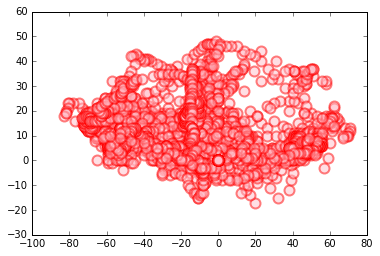

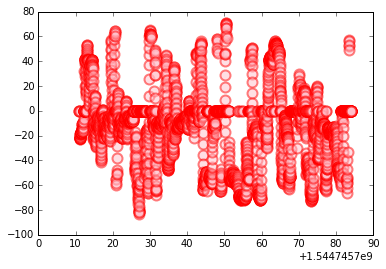

In [90]:
import matplotlib.pyplot as plt
print(len(df_omron['pt_yaw']))
a = np.zeros(len(df_omron['pt_yaw']))

plt.scatter(df_omron['pt_yaw'], df_omron['pt_pitch'], s=100, c="pink", alpha=0.5, linewidths="2", edgecolors="red")
plt.show()
#print(df['pt_yaw'])

plt.scatter(ts, df_omron['pt_yaw'], s=100, c="pink", alpha=0.5, linewidths="2", edgecolors="red")
plt.show()

In [35]:
#動画ファイルをグラブ
import cv2

video = OperaImage( opera )
videoCap = video.get_VideoCapture(tripLists,14)

print( video.get_SizeFrameCount(videoCap) )
print( video.get_FPS(videoCap) )
print( video.get_SizeFrameCount(videoCap)/video.get_FPS(videoCap) )
w = videoCap.get(cv2.CAP_PROP_FRAME_WIDTH)
h = videoCap.get(cv2.CAP_PROP_FRAME_HEIGHT)

/mnt/s3-combined/meidai/picamera1/picamera1-20190124134401.mp4
log date: 2019-01-24 13:44:01+09:00
open video file : True
12600
30.0
420.0


2
0.03333333333333333


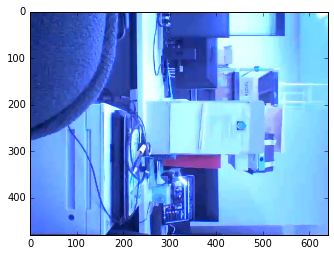

In [18]:
#view image
import matplotlib.pyplot as plt

video.set_FrameCount( videoCap, 1 )
ret, frame = video.read( videoCap )
# Capture frame-by-frame
#for i in range(0,10000):
#    ret, frame = video.read( videoCaps[0] )
    
if( ret == True ):
    print( video.get_FrameCount( videoCap ))
    print( (video.get_FrameCount( videoCap )-1)/video.get_FPS(videoCap) )
    # Display the resulting frame
    plt.imshow(frame)
    plt.show()

    #Nexus 6P (6.17mm sensor, 4.67mm) 66.9°37.2%
    #Nexus 6P 79deg
else:
    print("Reading is fail or end of video")

In [50]:
#Visible eye tracking on front view image 1. get data
#get current image time stamp ( sec )
sTime, cTime, eTime = video.get_TimeStamp( videoCap )
print(cTime)
margin = 5.0*60
df_tl = opera.get_DataLogIDFromTime( 'omron', sTime-margin, eTime, tripLists['oc_id'][14])

omron = OmronEye( opera )
column_names, df = omron.get_DataFrameFromDuration( cTime-5/2, 5, df_tl['id'] )

#print(df)
#print(column_names)
#print('Read recoard len : ' + str(len(df)))
#print('Time [s]' + str((df['time'][len(df)-1]-df['time'][0])/1000) )

1548305041.0
SELECT * FROM data_logs WHERE log_date > '2019-01-24 13:39:01+09:00' AND log_date < '2019-01-24 13:51:01+09:00' AND sensor_name = 'omron' AND oc_id = 'meidai';
SELECT * FROM omrons WHERE (save_time > 1548305038500.0 AND save_time < 1548305043500.0 ) AND ( data_log_id = '82' );


70


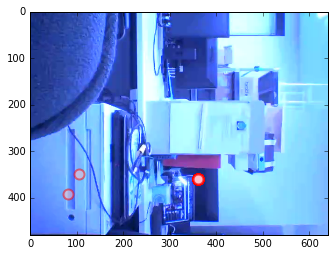

In [51]:
#Visible eye tracking on front view image 2. visualize
import matplotlib.pyplot as plt
import math

fx = 600
fy = fx
x=[]
y=[]
for yaw in df['gb_yaw']:
    x.append( w/2 - fx*math.tan(math.radians(yaw)) + 40 ) 
    
for pitch in df['gb_pitch']:
    y.append( h/2 - fx*math.tan(math.radians(pitch)) + 120)

print(len(df['pt_yaw']))
a = np.zeros(len(df['gb_yaw']))
plt.scatter(x, y, s=100, c="pink", alpha=0.5, linewidths="2", edgecolors="red")

img = np.array( frame )
plt.imshow(img)
plt.show()


In [ ]:
#Get Eye data
#ToDo library
l=2
start_datetime = df_tripLists['start_time'][l]
stop_datetime = start_datetime + df_tripLists['length'][l]

print

#Create Query
query_omroncamera = 'SELECT * FROM driveragent_omroncamera'
datetime_conditions = ' WHERE id = ' +  "'" + str(df_tripLists['id'][l]) + "'"
#datetime_conditions = ' WHERE id = ' +  "'03797146-9141-11e8-921d-06dc25b93fb2'"
test_opt = ' ORDER BY time ASC LIMIT 100'
query = query_omroncamera + datetime_conditions + test_opt + ';'

print(query)

try:
    cur.execute(query)
    print('Get column names')
    column_names = [desc[0] for desc in cur.description]
    print(column_names)
    df = pd.DataFrame(columns=column_names)
    
    for row in cur.fetchall():
        df_ = pd.Series(list(row), index=column_names)
        df = df.append(df_, ignore_index=True)
    
    print('Read recoard len : ' + str(len(df)))

except Exception as e:
    #
    conn.rollback()
    print( e.pgerror )

In [22]:
#タイムスタンプのチェック
from datetime import datetime, timezone, timedelta

#now = 1532651953073/1000
now = 1532666822706/1000
utc = datetime.fromtimestamp(now, timezone.utc)
print(utc)

JST = timezone(timedelta(hours=+9), 'JST')
loc = datetime.fromtimestamp(now, JST)
print(loc)

#Get time from video
desire_date = '2018-07-27'
desire_length = pd.Timedelta('23:59:59')

#ToDo library
desire_time = '00:00:00.0000'
desire_datetime = desire_date + ' ' + desire_time
start_datetime = pd.Timestamp(desire_datetime)
stop_datetime = start_datetime + desire_length

mysql_datetime = int(time.mktime(start_datetime.timetuple()))*1000
mysql_stoptime = int(time.mktime(stop_datetime.timetuple()))*1000

print(mysql_datetime)



2018-07-27 04:47:02.706000+00:00
2018-07-27 13:47:02.706000+09:00
1532649600000


[autoreload of operaDB2 failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/usr/lib/python3.5/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.5/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 626, in _exec
  File "<frozen importlib._bootstrap_external>", line 661, in exec_module
  File "<frozen importlib._bootstrap_external>", line 767, in get_code
  File "<frozen importlib._bootstrap_external>", line 727, in source_to_code
  File "<frozen importlib._bootstrap>", line 222, in _call_with_frames_removed
  File "/home/masayuki/opera/Harmoware-BIO/operaDB2.py", line 130
    print( query )
    ^
Ind

In [60]:
#未実装
#目線と地図
import numpy as np
import pandas as pd
import urllib.request
import math
import pyproj
import folium
from IPython.display import display
from scipy import signal, interpolate

#gps
gps = GPS( opera )
#OBD
obd = OBD( opera )

sTimeStamp = df_omron['time'][0]
eTimeStamp = df_omron['time'][len(df_omron['time'])-1]

column_names, df_gps = gps.get_DataFrameFromTime( sTimeStamp, eTimeStamp )
column_names, df_obd = obd.get_DataFrameFromTime( sTimeStamp, eTimeStamp )#
print( 'finish to get gps and obd data')

#check timestamp for interpolate
if( sTimeStamp < df_gps['time'][0] ):
    sTimeStamp = df_gps['time'][0]

if( sTimeStamp < df_obd['time'][0] ):
    sTimeStamp = df_obd['time'][0]

if( df_gps['time'][len(df_gps['time'])-1] < eTimeStamp ):
    eTimeStamp = df_gps['time'][len(df_gps['time'])-1]

if( df_obd['time'][len(df_obd['time'])-1] < eTimeStamp ):
    eTimeStamp = df_obd['time'][len(df_obd['time'])-1]

column_names, df_omron = omron.get_DataFrameFromTime( sTimeStamp, eTimeStamp )#
print( 'finish to get omron data')
    
#interpolate linear
f_gps_lat = interpolate.interp1d(np.array(df_gps['time'],dtype=np.float),df_gps['latitude'])
gps_lat_ip = f_gps_lat(np.array(df_omron['time'],dtype=np.float))

f_gps_lon = interpolate.interp1d(np.array(df_gps['time'],dtype=np.float),df_gps['longitude'])
gps_lon_ip = f_gps_lon(np.array(df_omron['time'],dtype=np.float))

f_gps_bear = interpolate.interp1d(np.array(df_gps['time'],dtype=np.float),df_gps['bearing'])
gps_bear_ip = f_gps_bear(np.array(df_omron['time'],dtype=np.float))

f_vehicle_speed = interpolate.interp1d(np.array(df_obd['time'],dtype=np.float),df_obd['vehicle_speed'])
vehicle_speed_interpolate = f_vehicle_speed(np.array(df_omron['time'],dtype=np.float))

loc = [gps_lat_ip[0], gps_lon_ip[0]]
map_obj =folium.Map(location=loc, zoom_start=14)

# 変換元の座標系：緯度経度
p1 = pyproj.Proj(init='epsg:4612')
# 変換先の座標系：平面直角座標系 ９系
p2 = pyproj.Proj(init='epsg:2451')

#視線の距離(時間*車速)
tt = 2.0;
print(len(df_omron['gb_yaw']))
#for i in range(len(df_omron['gb_yaw'])):
for i in range(1000,7000,10):
    headaway_distance = tt * vehicle_speed_interpolate[i]/3.6
    if( headaway_distance < 20 ):
        headaway_distance = 20
    # 変換
    y,x = pyproj.transform(p1, p2, gps_lon_ip[i], gps_lat_ip[i])

    sin_head = math.sin(math.radians(90-gps_bear_ip[i]-df_omron['gb_yaw'][i]))
    cos_head = math.cos(math.radians(90-gps_bear_ip[i]-df_omron['gb_yaw'][i]))

    x = x + headaway_distance*sin_head
    y = y + headaway_distance*cos_head

    long,lat = pyproj.transform(p2, p1, y, x)

    folium.PolyLine([[gps_lat_ip[i],gps_lon_ip[i]],[lat,long]],color="red", weight=2.5, opacity=1).add_to(map_obj)    
#    folium.CircleMarker([df_gps['latitude'][i],df_gps['longitude'][i]], radius=upStatus_interpolate[i]/100000,popup='',color='#3186cc', fill_color='#3186cc').add_to(map_obj)

display(map_obj)

finish to get gps and obd data
finish to get omron data
7563
